![Semillero Astrofisica](../../logo.png)

---
# Ecuaciones Diferenciales Parciales: Poisson con Operadores de Red


Carlos Andrés del Valle (cdelv@unal.edu.co)

---

Vamos a resolver la ecuación Poisson 

\begin{equation}
    -\nabla^2 u=\sum_{k=1}^4k\sin{kx}+8\sin{8x},\quad x\in[0,\pi]
\end{equation}

Con condiciones de frontera periódicas
\begin{equation}
    \begin{split}
        & u(0)=0 \\
        & u(\pi)=\pi \\
    \end{split}
\end{equation}

La solución analítica es
\begin{equation}
    u(x)=x+\sum_{k=1}^4\frac{\sin{kx}}{k}+\frac{\sin{8x}}{8}
\end{equation}

In [1]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np

#Usar doble precisión si la GPU lo soporta. Float32 por defecto.
dde.config.real.set_float64()
tf.keras.backend.set_floatx('float64')

Using backend: tensorflow.compat.v1

2022-10-22 09:52:37.559700: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-22 09:52:37.677332: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-22 09:52:37.681417: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-22 09:52:37.681432: I tensorflow/stream_executor/cuda/cudart_stub.cc:

Instructions for updating:
non-resource variables are not supported in the long term


2022-10-22 09:52:38.849397: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-22 09:52:38.849444: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist


## 1. Definir la Ecuación a Resolver

In [2]:
 def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    summation = sum([k*tf.sin(k*x) for k in range(1, 5)])
    return dy_xx + summation + 8*tf.sin(8*x)

def func(x):
    summation = sum([np.sin(k*x)/k for k in range(1, 5)])
    return x + summation + np.sin(8*x)/8

## 2. Definir Dominio de la Ecuación

In [3]:
geom = dde.geometry.Interval(0, np.pi)

## 3. Definir Condiciones Iniciales y de Frontera

No vamos a definir condiciones de frontera de la forma estandar, en lugar de eso, vamos a crear una operador de red que las va a imponer de forma fuerte. 

La idea es que 
\begin{equation}
    \hat{u}(x)=x(\pi-x)u(x)+x
\end{equation}

Entonces cuando estamos en una frontera, $u(0)=0$ o $u(\pi)=\pi$ se satisfacen las condiciones de frontera automáticamente. 

Como las redes neuronales de por sí no son lineales, no pasa nada si se definen estas transformaciones no lineales. 

In [4]:
def  output_transform(x, y):
    return x*(np.pi - x)*y + x

#net.apply_output_transform(output_transform) #tenemos que colocar esto después de definir la red

## 4. Crear Datos de Entrenamiento

vamos a crear los datos de entrenamiento

In [5]:
data = dde.data.PDE(geom, pde, [], num_domain=126, solution=func, num_test=200, train_distribution='uniform')

## 5. Crear la Red Neuronal

Como el término forzante se compone de senos, entonces la solución será una combinación lineal de senos. Es por esto que podemos aprovechar aún más los operadores de la red y aplicar una transformada de fourier a la red para conseguir una mejor solución

~~~python
class deepxde.nn.tensorflow_compat_v1.msffn.MsFFN(layer_sizes, 
                                                  activation, 
                                                  kernel_initializer, 
                                                  sigmas, 
                                                  regularization=None, 
                                                  dropout_rate=0, 
                                                  batch_normalization=None, 
                                                  layer_normalization=None, 
                                                  kernel_constraint=None, 
                                                  use_bias=True)
~~~

También existe una versión para problemas con dependencia temporal. Ver detalles en https://deepxde.readthedocs.io/en/latest/modules/deepxde.nn.tensorflow_compat_v1.html?highlight=nn.MsFFN#deepxde.nn.tensorflow_compat_v1.msffn.MsFFN. 

- **sigmas** – List of standard deviation of the distribution of fourier feature embeddings

In [6]:
layer_size = [1] + [40]*3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.MsFFN(layer_size, activation, initializer, sigmas=[1, 10])

net.apply_output_transform(output_transform) # aplicar la transformación

## 6. Compilar y Entrenar el Modelo

Vamos a utilizar otra opción que no hemos usado hasta ahora para el optimizador Adam. Esto es que el learning rate disminuya con las iteraciones. Ver https://deepxde.readthedocs.io/en/latest/modules/deepxde.html?highlight=decay#deepxde.model.Model.compile.

In [7]:
# Modelo
model = dde.Model(data, net)

# Optimizador Adam
model.compile(
    "adam",
    lr=3e-4,
    metrics=["l2 relative error"],
    decay=("inverse time", 1500, 0.9), # es posible hacer que el learning rate disminuya con las iteraciones
)

losshistory, train_state = model.train(iterations=25000)

Compiling model...
Building Multiscale Fourier Feature Network...


/home/wind/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2022-10-22 09:52:40.191101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'compile' took 0.551420 s

Initializing variables...
Training model...



2022-10-22 09:52:40.708621: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Step      Train loss    Test loss     Test metric   
0         [1.35e+04]    [1.34e+04]    [1.01e+00]    
1000      [1.34e+00]    [1.38e+00]    [2.04e-01]    
2000      [2.71e-01]    [2.91e-01]    [3.58e-02]    
3000      [1.23e-01]    [1.38e-01]    [5.53e-03]    
4000      [7.16e-02]    [8.52e-02]    [1.78e-03]    
5000      [4.45e-02]    [5.76e-02]    [8.02e-04]    
6000      [2.90e-02]    [4.04e-02]    [2.98e-04]    
7000      [1.94e-02]    [2.84e-02]    [8.92e-05]    
8000      [1.31e-02]    [1.99e-02]    [2.85e-05]    
9000      [8.76e-03]    [1.41e-02]    [1.82e-05]    
10000     [5.67e-03]    [1.04e-02]    [1.92e-05]    
11000     [3.47e-03]    [8.09e-03]    [2.21e-05]    
12000     [2.03e-03]    [6.86e-03]    [3.18e-05]    
13000     [1.16e-03]    [6.34e-03]    [3.96e-05]    
14000     [9.24e-04]    [6.47e-03]    [4.27e-05]    
15000     [5.16e-04]    [6.42e-03]    [5.17e-05]    
16000     [5.11e-04]    [6.70e-03]    [6.83e-05]    
17000     [1.95e-04]    [6.63e-03]    [5.34e-0

## 7. Visualizar la Solución

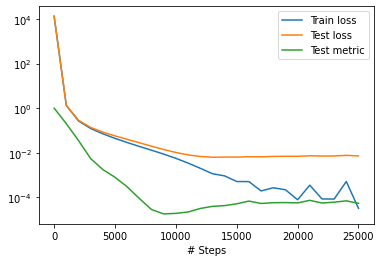

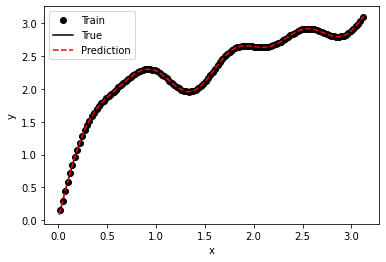

In [8]:
dde.saveplot(model.losshistory, model.train_state, issave=False, isplot=True)